<a href="https://colab.research.google.com/github/maryambahri/recession_analysis/blob/main/scripts/Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
!pip install boto3 pandas requests


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.3/14.3 MB 88.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 8.5 MB/s eta 0:00:00


In [29]:
# loading all libraries here

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import boto3
import os
from datetime import datetime
import io

# === EDIT THESE ===
AWS_ACCESS_KEY_ID = "xxxxxxxxxxxxxxxxxxxxxxxx"
AWS_SECRET_ACCESS_KEY = "xxxxxxxxxxxxxxxxxxxxxxxxx"
AWS_REGION = "us-east-1"   # or whatever region you use
S3_BUCKET_NAME = "group24-recessionanalysis"
S3_PREFIX = "cleansed_data/"

# Create S3 client using your keys
s3_client = boto3.client(
    "s3",
    aws_access_key_id=AWS_ACCESS_KEY_ID,
    aws_secret_access_key=AWS_SECRET_ACCESS_KEY,
    region_name=AWS_REGION,
)

print("S3 client created OK")

#!git clone https://github.com/maryambahri/recession_analysis.git


S3 client created OK


In [30]:
import pandas as pd
from pandas.errors import ParserError

paginator = s3_client.get_paginator("list_objects_v2")

dataframes = {}

for page in paginator.paginate(Bucket=S3_BUCKET_NAME, Prefix=S3_PREFIX):
    for obj in page.get("Contents", []):
        key = obj["Key"]

        if key.endswith("/"):
            continue

        print(f"Found file in S3: {key}")

        if key.lower().endswith(".csv"):
            try:
                # First attempt: plain CSV
                s3_obj = s3_client.get_object(Bucket=S3_BUCKET_NAME, Key=key)
                df = pd.read_csv(s3_obj["Body"])
            except ParserError:
                # Second attempt: World Bank-style CSV with 4 metadata lines
                print(f"ParserError for {key}, retrying with skiprows=4")
                s3_obj = s3_client.get_object(Bucket=S3_BUCKET_NAME, Key=key)
                df = pd.read_csv(s3_obj["Body"], skiprows=4)
        elif key.lower().endswith((".xlsx", ".xls")):
            s3_obj = s3_client.get_object(Bucket=S3_BUCKET_NAME, Key=key)
            df = pd.read_excel(s3_obj["Body"])
        else:
            print(f"Skipping unsupported file type: {key}")
            continue

        base_name = os.path.basename(key)
        name_no_ext = os.path.splitext(base_name)[0]
        dataframes[name_no_ext] = df
        print(f"Loaded into DataFrame: dataframes['{name_no_ext}']")

print("\nLoaded DataFrames:")
for name, df in dataframes.items():
    print(f"- {name}: {df.shape}")


Found file in S3: cleansed_data/processed_dataset.csv
Loaded into DataFrame: dataframes['processed_dataset']
Found file in S3: cleansed_data/toS3.txt
Skipping unsupported file type: cleansed_data/toS3.txt

Loaded DataFrames:
- processed_dataset: (229, 5)


In [31]:
clean_df = dataframes["processed_dataset"]
clean_df.head()


,Year,GDP_growth_rate,Unemployment_rate,Inflation_rate,Recession_Tag
0,1967,2.742666,3.8,2.772786,0
1,1968,4.914509,3.6,4.271796,0
2,1968,4.914509,3.6,4.271796,0
3,1968,4.914509,3.6,4.271796,0
4,1968,4.914509,3.6,4.271796,0


-------------------------------------------------------------------------------
# **Pearson Correlation Analysis for dataset**

In [32]:
corr_years = clean_df[['GDP_growth_rate',
                'Unemployment_rate',
                'Inflation_rate',
                'Recession_Tag']].corr(method='pearson')

corr_years


,GDP_growth_rate,Unemployment_rate,Inflation_rate,Recession_Tag
GDP_growth_rate,1.000000,-0.293529,-0.078566,-0.463283
Unemployment_rate,-0.293529,1.000000,0.053213,0.035508
Inflation_rate,-0.078566,0.053213,1.000000,0.398143
Recession_Tag,-0.463283,0.035508,0.398143,1.000000


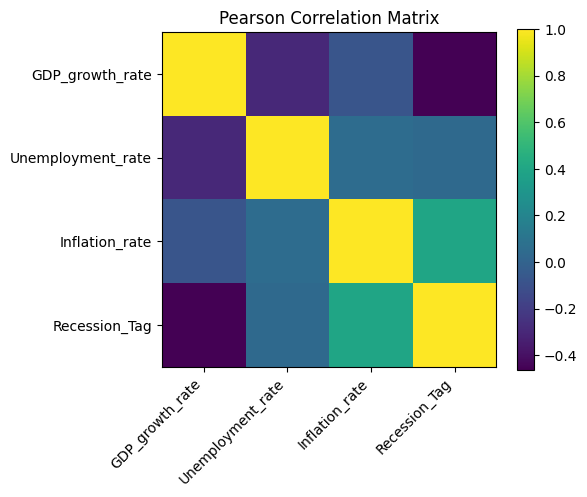

In [33]:
# now we visualize

plt.figure(figsize=(6,5))
plt.imshow(corr_years, interpolation='nearest')
plt.xticks(range(len(corr_years.columns)), corr_years.columns, rotation=45, ha='right')
plt.yticks(range(len(corr_years.index)), corr_years.index)
plt.colorbar()
plt.title("Pearson Correlation Matrix")
plt.tight_layout()
plt.show()


-------------------------------------------------------------------------------
# **Pearson Correlation Analysis for a Sliding 2-Year Window**

In [34]:
# Select features columns for the correlation

features = ['GDP_growth_rate', 'Unemployment_rate', 'Inflation_rate']

results = []

years = clean_df['Year'].unique()

for i in range(len(years) - 1):
    start_year = years[i]
    end_year = years[i + 1]

    # Subset the 2-year window
    window = clean_df[(clean_df['Year'] >= start_year) & (clean_df['Year'] <= end_year)]

    # Check if we have enough variation in the target
    if window['Recession_Tag'].nunique() < 2:
        results.append({
            'Window': f"{start_year}-{end_year}",
            'Highest_Corr_Feature': None,
            'Highest_Corr_Value': None,
            'Lowest_Corr_Feature': None,
            'Lowest_Corr_Value': None
        })
        continue

    # Calculate correlation
    corr = window[features + ['Recession_Tag']].corr()['Recession_Tag'].drop('Recession_Tag')
    corr = corr.dropna()

    if corr.empty:
        results.append({
            'Window': f"{start_year}-{end_year}",
            'Highest_Corr_Feature': None,
            'Highest_Corr_Value': None,
            'Lowest_Corr_Feature': None,
            'Lowest_Corr_Value': None
        })
        continue

    results.append({
        'Window': f"{start_year}-{end_year}",
        'Highest_Corr_Feature': corr.idxmax(),
        'Highest_Corr_Value': corr.max(),
        'Lowest_Corr_Feature': corr.idxmin(),
        'Lowest_Corr_Value': corr.min()
    })

two_year_corr_df = pd.DataFrame(results)
two_year_corr_df


,Window,Highest_Corr_Feature,Highest_Corr_Value,Lowest_Corr_Feature,Lowest_Corr_Value
0,1967-1968,None,NaN,None,NaN
1,1968-1969,Inflation_rate,0.774597,GDP_growth_rate,-0.774597
2,1969-1970,Unemployment_rate,0.377964,GDP_growth_rate,-0.377964
3,1970-1971,Inflation_rate,1.000000,GDP_growth_rate,-1.000000
4,1971-1972,None,NaN,None,NaN
5,1972-1973,Inflation_rate,0.377964,Unemployment_rate,-0.377964
6,1973-1974,Inflation_rate,0.774597,GDP_growth_rate,-0.774597
7,1974-1975,Inflation_rate,0.774597,GDP_growth_rate,-0.774597
8,1975-1976,Unemployment_rate,0.377964,GDP_growth_rate,-0.377964
9,1976-1977,None,NaN,None,NaN


In [38]:
two_year_corr_df = pd.DataFrame(results)

# Convert DataFrame to CSV in memory (no file on disk)
csv_buffer = io.StringIO()
two_year_corr_df.to_csv(csv_buffer, index=False)

# Define the S3 key (path inside bucket)
RESULT_PREFIX = "result/"   # or "output/" if you prefer
timestamp = datetime.utcnow().strftime("%Y%m%d_%H%M%S")
result_key = f"{RESULT_PREFIX}two_year_corr_{timestamp}.csv"

# Upload to S3
s3_client.put_object(
    Bucket=S3_BUCKET_NAME,
    Key=result_key,
    Body=csv_buffer.getvalue()
)

print(f"Uploaded result to s3://{S3_BUCKET_NAME}/{result_key}")

/tmp/ipython-input-1868067009.py:9: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  timestamp = datetime.utcnow().strftime("%Y%m%d_%H%M%S")


Uploaded result to s3://group24-recessionanalysis/result/two_year_corr_20251123_175755.csv
